In [1]:
BATCH_SIZE = 10
EPOCHS = 15
LEARNING_RATE = 0.1
SEED = 42

In [2]:
import torch
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../examples/datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('../examples/datasets/mc_dev_data.txt')
test_labels, test_data = read_data('../examples/datasets/mc_test_data.txt')

In [ ]:
import os

TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

In [4]:
train_data[:5]

['skillful man prepares sauce .',
 'skillful man bakes dinner .',
 'woman cooks tasty meal .',
 'man prepares meal .',
 'skillful woman debugs program .']

In [5]:
train_labels[:5]

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0]]

In [6]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [7]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

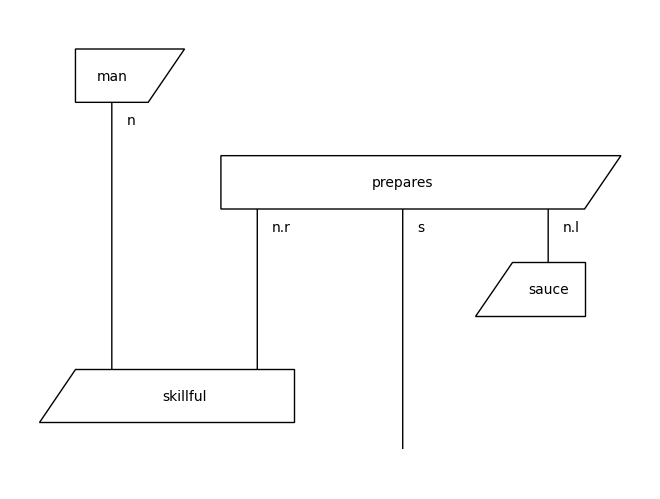

In [8]:
train_diagrams[0].draw()

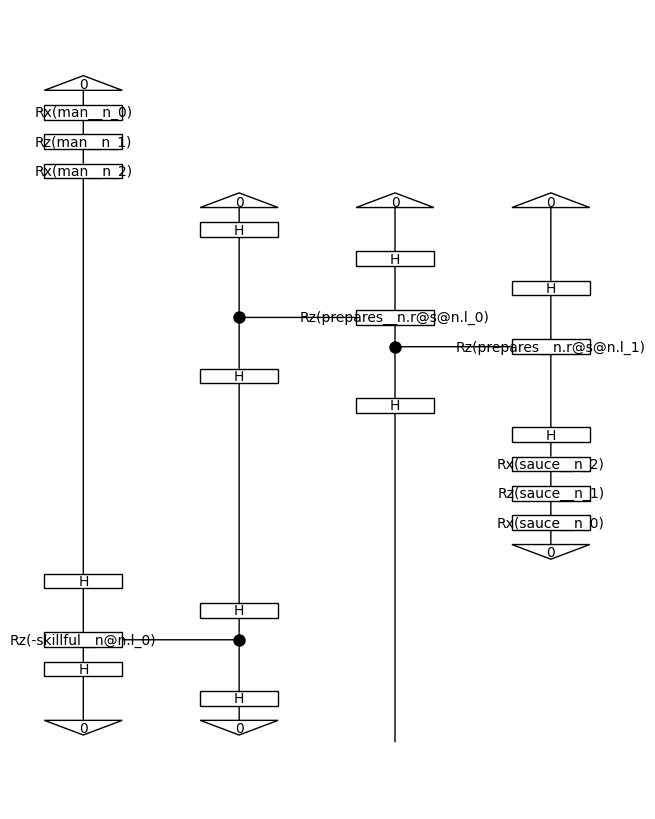

In [9]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

In [10]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + dev_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

In [11]:
import pennylane as qml

qml.default_config['qiskit.ibmq.ibmqx_token'] = 'my_API_token'
qml.default_config.save(qml.default_config.path)
backend_config = {'backend': 'qiskit.ibmq',
                  'device': 'ibmq_manila',
                  'shots': 1000}

In [ ]:
if TESTING:
    backend_config = None

In [12]:
q_model = PennyLaneModel.from_diagrams(all_circuits,
                                       probabilities=True,
                                       normalize=True,
                                       backend_config=backend_config)
q_model.initialise_weights()

In [13]:
qml.default_config['honeywell.global.user_email'] = ('my_Honeywell/Quantinuum_'
                                                     'account_email')
qml.default_config.save(qml.default_config.path)

backend_config = {'backend': 'honeywell.hqs',
                  'device': 'H1-1E',
                  'shots': 1000}

In [ ]:
if TESTING:
    backend_config = None

In [14]:
h_model = PennyLaneModel.from_diagrams(all_circuits,
                                       probabilities=True,
                                       normalize=True,
                                       backend_config=backend_config)
h_model.initialise_weights()

In [15]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels)

In [16]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [17]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [18]:
trainer.fit(train_dataset, val_dataset)

Epoch 1:   train/loss: 0.1960   valid/loss: 0.1342   train/acc: 0.7143   valid/acc: 0.8333
Epoch 2:   train/loss: 0.1601   valid/loss: 0.1364   train/acc: 0.7714   valid/acc: 0.8000
Epoch 3:   train/loss: 0.1128   valid/loss: 0.2288   train/acc: 0.8143   valid/acc: 0.7000
Epoch 4:   train/loss: 0.1268   valid/loss: 0.1971   train/acc: 0.8143   valid/acc: 0.7000
Epoch 5:   train/loss: 0.0952   valid/loss: 0.2377   train/acc: 0.8857   valid/acc: 0.6333
Epoch 6:   train/loss: 0.0944   valid/loss: 0.1429   train/acc: 0.8429   valid/acc: 0.8000
Epoch 7:   train/loss: 0.0491   valid/loss: 0.1007   train/acc: 0.9286   valid/acc: 0.9000
Epoch 8:   train/loss: 0.0227   valid/loss: 0.1004   train/acc: 0.9714   valid/acc: 0.8333
Epoch 9:   train/loss: 0.0240   valid/loss: 0.0609   train/acc: 0.9857   valid/acc: 0.9333
Epoch 10:  train/loss: 0.0184   valid/loss: 0.0518   train/acc: 0.9714   valid/acc: 0.9333
Epoch 11:  train/loss: 0.0093   valid/loss: 0.0420   train/acc: 1.0000   valid/acc: 0.9667

Final test accuracy: 0.9666666666666667


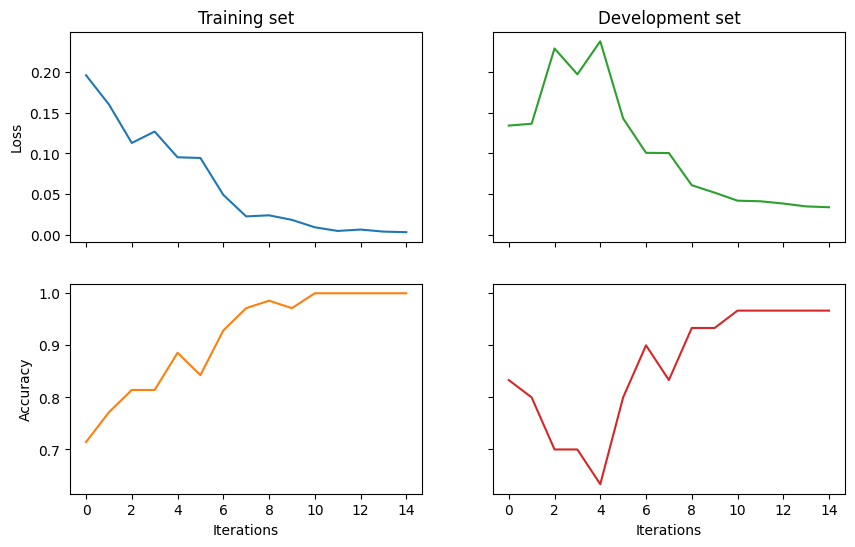

In [19]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

In [20]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) ==
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

In [21]:
model = PennyLaneModel.from_diagrams(all_circuits)
model.initialise_weights()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_dataset:
        optimizer.zero_grad()
        probs = model(circuits)
        loss = torch.nn.functional.mse_loss(probs,
                                            torch.tensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    if i % 5 == 0:
        dev_acc = accuracy(dev_circuits, dev_labels)

        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))

        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save('model.lt')
        elif i - best['epoch'] >= 10:
            print('Early stopping')
            break

if best['acc'] > accuracy(dev_circuits, dev_labels):
    model.load('model.lt')

Epoch: 0
Train loss: 2.247520089149475
Dev acc: 0.6333333333333333
Epoch: 5
Train loss: 0.646653838455677
Dev acc: 0.9333333333333333
Epoch: 10
Train loss: 0.3163997186347842
Dev acc: 1.0


In [22]:
print('Final test accuracy: {}'.format(accuracy(test_circuits, test_labels)))

Final test accuracy: 1.0


In [23]:
BATCH_SIZE = 50
EPOCHS = 100
LEARNING_RATE = 0.1
SEED = 2

In [24]:
from torch import nn

class XORSentenceModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

        self.xor_net = nn.Sequential(nn.Linear(4, 10),
                                     nn.ReLU(),
                                     nn.Linear(10, 1),
                                     nn.Sigmoid())

    def forward(self, diagram_pairs):
        first_d, second_d = zip(*diagram_pairs)
        evaluated_pairs = torch.cat((self.get_diagram_output(first_d),
                                     self.get_diagram_output(second_d)),
                                    dim=1)
        evaluated_pairs = 2 * (evaluated_pairs - 0.5)
        return self.xor_net(evaluated_pairs)


In [25]:
from itertools import combinations

def make_pair_data(diagrams, labels):
    pair_diags = list(combinations(diagrams, 2))
    pair_labels = [int(x[0] == y[0]) for x, y in combinations(labels, 2)]
    return pair_diags, pair_labels

train_pair_circuits, train_pair_labels = make_pair_data(train_circuits,
                                                        train_labels)
dev_pair_circuits, dev_pair_labels = make_pair_data(dev_circuits,
                                                    dev_labels)
test_pair_circuits, test_pair_labels = make_pair_data(test_circuits,
                                                      test_labels)

In [26]:
TRAIN_SAMPLES, DEV_SAMPLES, TEST_SAMPLES = 300, 200, 200

In [ ]:
if TESTING:
    TRAIN_SAMPLES, DEV_SAMPLES, TEST_SAMPLES = 1, 1, 1

In [27]:
train_pair_circuits, train_pair_labels = (
    zip(*random.sample(list(zip(train_pair_circuits, train_pair_labels)), 
                       TRAIN_SAMPLES)))
dev_pair_circuits, dev_pair_labels = (
    zip(*random.sample(list(zip(dev_pair_circuits, dev_pair_labels)), DEV_SAMPLES)))
test_pair_circuits, test_pair_labels = (
    zip(*random.sample(list(zip(test_pair_circuits, test_pair_labels)), TEST_SAMPLES)))

In [28]:
all_pair_circuits = (train_pair_circuits +
                     dev_pair_circuits +
                     test_pair_circuits)
a, b = zip(*all_pair_circuits)

model = XORSentenceModel.from_diagrams(a + b)
model.initialise_weights()
model = model

train_pair_dataset = Dataset(train_pair_circuits,
                             train_pair_labels,
                             batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [29]:
def accuracy(circs, labels):
    predicted = model(circs)
    return (torch.round(torch.flatten(predicted)) ==
            torch.Tensor(labels)).sum().item()/len(circs)

In [30]:
best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_pair_dataset:
        optimizer.zero_grad()
        predicted = model(circuits)
        loss = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.Tensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    if i % 5 == 0:
        dev_acc = accuracy(dev_pair_circuits, dev_pair_labels)

        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))

        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save('xor_model.lt')
        elif i - best['epoch'] >= 10:
            print('Early stopping')
            break

if best['acc'] > accuracy(dev_pair_circuits, dev_pair_labels):
    model.load('xor_model.lt')
    model = model

Epoch: 0
Train loss: 4.063989102840424
Dev acc: 0.475
Epoch: 5
Train loss: 0.8724211193621159
Dev acc: 0.84
Epoch: 10
Train loss: 2.4435547292232513
Dev acc: 0.59
Epoch: 15
Train loss: 2.319866120815277
Dev acc: 0.705
Early stopping


In [31]:
print('Final test accuracy: {}'.format(accuracy(test_pair_circuits,
                                                test_pair_labels)))

Final test accuracy: 0.845


In [32]:
xor_labels = [[1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0]]
# the first two entries correspond to the same label for both sentences, the last two to different labels
xor_tensors = torch.tensor(xor_labels).float()

model.xor_net(xor_tensors).detach().numpy()

array([[8.9938962e-01],
       [9.2139769e-01],
       [4.6886431e-04],
       [2.2565764e-01]], dtype=float32)

In [33]:
FOOD_IDX, IT_IDX = 0, 6
symbol_weight_map = dict(zip(model.symbols, model.weights))

In [ ]:
if TESTING: 
    FOOD_IDX, IT_IDX = 0, 0

In [34]:
print(test_data[FOOD_IDX])

p_circ = test_circuits[FOOD_IDX].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(symbol_weight_map)
unnorm = p_circ.eval().detach().numpy()

unnorm / np.sum(unnorm)

woman prepares tasty dinner .


array([0.17773626, 0.82226374])

In [35]:
print(test_data[IT_IDX])

p_circ = test_circuits[IT_IDX].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(symbol_weight_map)
unnorm = p_circ.eval().detach().numpy()

unnorm / np.sum(unnorm)

skillful person runs software .


array([0.94869445, 0.05130555])